In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import neurokit2 as nk
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# AdVitam ECG Data

In [2]:
driver_physio_data = "../AdVitam/Exp2/Raw/Physio/Txt/NST01.txt"
driver_physio_markers = "../AdVitam/Exp2/Raw/Physio/Txt/NST01-markers.txt"
driver_driving_data = "../AdVitam/Exp2/Raw/Driving/NST01.txt"

# physiological data
physio_data = pd.read_csv(
    driver_physio_data,
    sep="\t",
    header=9,
    skiprows=[10],
    usecols=[0, 1, 2, 3],
)

# ECG data
nst01_ecg_data = physio_data[["CH2"]]
nst01_ecg_data = nst01_ecg_data.values.reshape(-1)

# markers
physio_markers = pd.read_csv(driver_physio_markers, header=2, sep="\t")

# driving data
driving_data = pd.read_csv(driver_driving_data)

C:\Users\joelm\AppData\Local\Temp\ipykernel_8628\484979592.py:22: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  driving_data = pd.read_csv(driver_driving_data)


---

### Process ECG Data

In [3]:
'''Process the ECG data'''
signals, info = nk.ecg_process(nst01_ecg_data, sampling_rate=1000)

# Add the timestamps to the signals data
timestamps = physio_data[["min"]].values.reshape(-1)
signals["Timestamps"] = timestamps
# Convert the timestamps to timedelta
signals["Timestamps"] = pd.to_timedelta(signals["Timestamps"], unit="m")
signals = signals.set_index("Timestamps")

In [4]:
'''Segment the data into baseline, training, and experiment periods.'''
# baseline
baseline_start = pd.to_timedelta(physio_markers["Time(sec.):"][0], unit="s")
baseline_end = pd.to_timedelta(physio_markers["Time(sec.):"][1], unit="s")
baseline_data = signals[baseline_start:baseline_end]

# training
training_start = pd.to_timedelta(physio_markers["Time(sec.):"][2], unit="s")
training_end = pd.to_timedelta(physio_markers["Time(sec.):"][3], unit="s")
training_data = signals[training_start:training_end]

# experiment
experiment_start = pd.to_timedelta(physio_markers["Time(sec.):"][4], unit="s")
experiment_end = pd.to_timedelta(physio_markers["Time(sec.):"][5], unit="s")
experiment_data = signals[experiment_start:experiment_end]

---

### Process Driving Data

In [5]:
# Label Encode the Obstacles
driving_data = driving_data.fillna("Nothing")
# encoder = preprocessing.LabelEncoder()
# driving_data['Obstacles'] = encoder.fit_transform(driving_data['Obstacles'])

# Convert the time to timedelta
driving_data["Time"] = pd.to_timedelta(driving_data["Time"], unit="s")
driving_data = driving_data.set_index("Time")

---

### Aligning Data Timesteps 

In [6]:
# Comparing the time of the two datasets
driving_data_time = driving_data.index.max() - driving_data.index.min()
physio_data_time = experiment_data.index.max() - experiment_data.index.min()
print(f"Driving data time: {driving_data_time}, Physio data time: {physio_data_time}")

Driving data time: 0 days 00:20:44.260800, Physio data time: 0 days 00:20:00.960000


In [7]:
# Import the timestamps for the obstacles
nst01_ecg_timestamps = pd.read_csv(
    "../AdVitam/Exp2/Preprocessed/Physio and Driving/timestamps_obstacles.csv",
).head(1)
nst01_ecg_timestamps

# Drop the columns that are not needed
columns_to_drop = ['subject_id', 'label_st']
columns_to_drop += [col for col in nst01_ecg_timestamps.columns if 'Det' in col or 'Rep' in col]
nst01_ecg_timestamps.drop(columns=columns_to_drop, inplace=True)

In [8]:
# Add Obstacles Column to the ECG data
experiment_data.loc[:, "Obstacles"] = "Nothing"

# Add the obstacle to the experiment data
experiment_start = experiment_data.index.min()
trigger_obstacle = pd.to_timedelta(nst01_ecg_timestamps["TrigObsDeer"], unit="s")
# get the first index of the trigger obstacle
obstacle_trigger = experiment_data.index[experiment_data.index >= trigger_obstacle[0] + experiment_start][0]
# add the obstacle to the experiment data
experiment_data.loc[experiment_data.index == obstacle_trigger, "Obstacles"] = "TriggeredObs1"

C:\Users\joelm\AppData\Local\Temp\ipykernel_8628\2074383128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment_data.loc[:, "Obstacles"] = "Nothing"


---

### Plot ECG and Vehicle Data

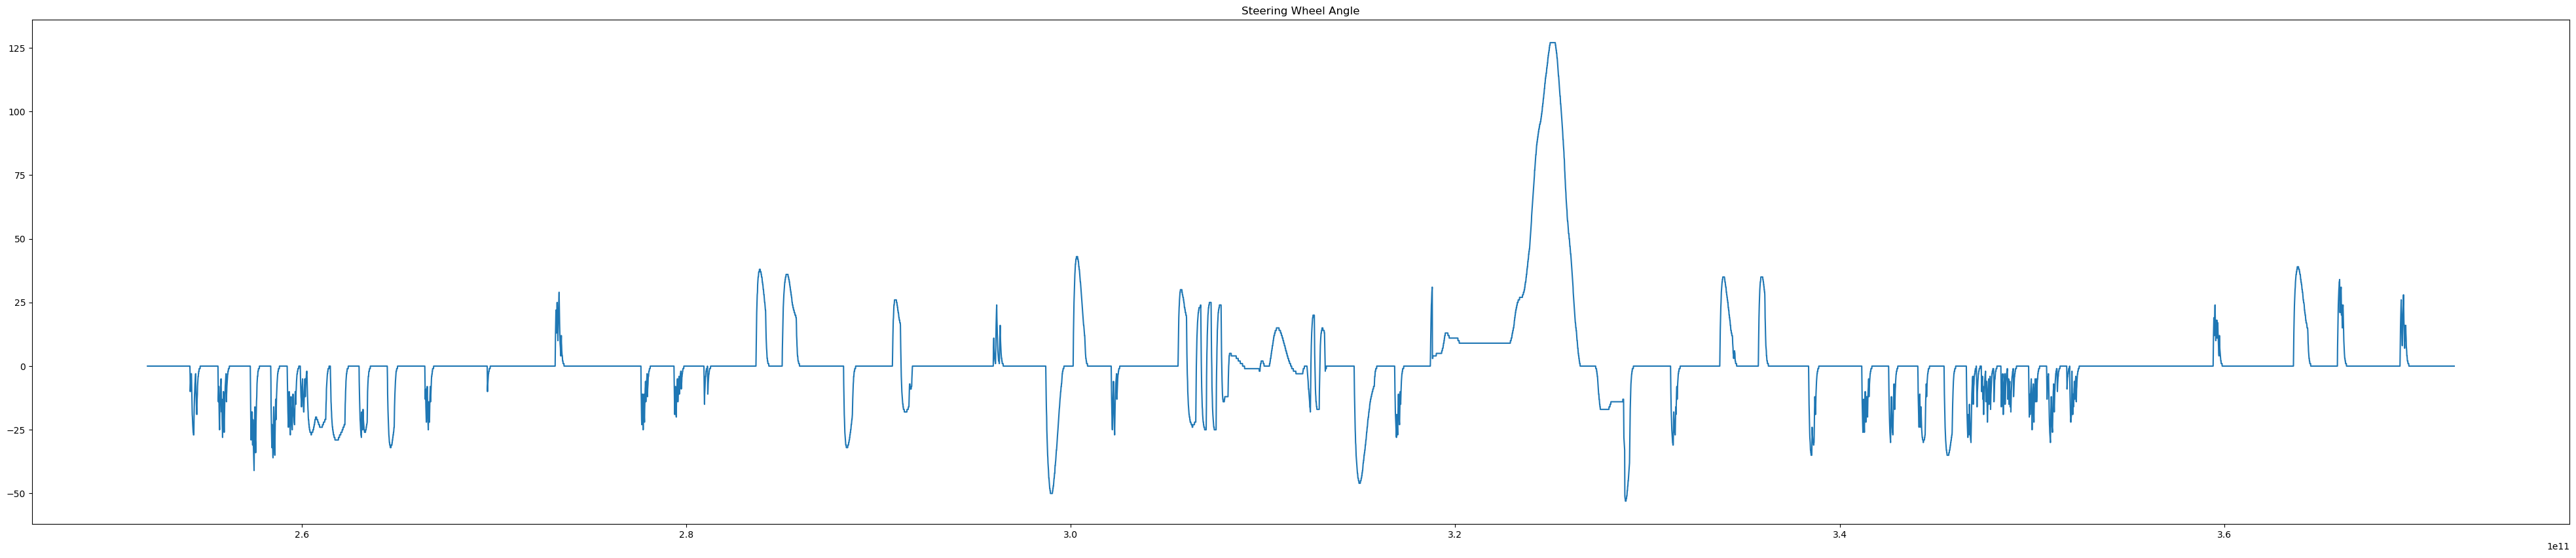

In [9]:
driving_obstacle_trigger = driving_data[driving_data["Obstacles"] == "TriggeredObs1"].index[0]
driving_obstacle_trigger

# plot driving data 1 minute before and after the obstacle
driving_data_1min_before = driving_data.loc[driving_obstacle_trigger - pd.Timedelta(minutes=1):driving_obstacle_trigger + pd.Timedelta(minutes=1)]
plt.figure(figsize=(50, 10))
plt.plot(driving_data_1min_before.index, driving_data_1min_before["SteeringWheelAngle"])
plt.title("Steering Wheel Angle")
plt.show()

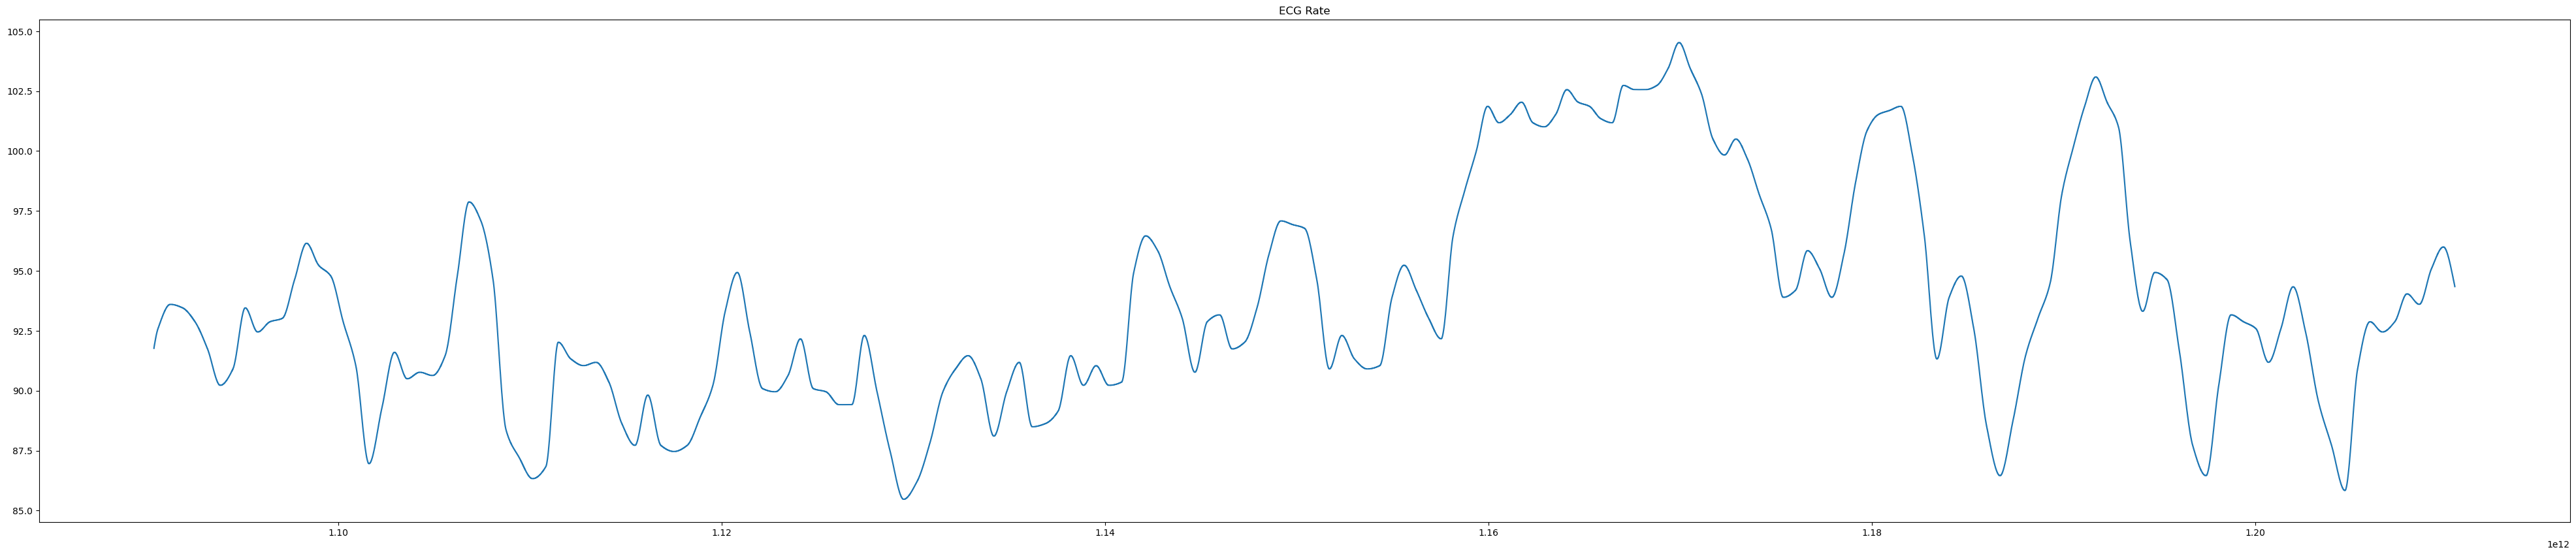

In [10]:
# plot the ECG data 1 minute before and after the obstacle
experiment_data_1min_before = experiment_data.loc[obstacle_trigger - pd.Timedelta(minutes=1):obstacle_trigger + pd.Timedelta(minutes=1)]
plt.figure(figsize=(50, 10))
plt.plot(experiment_data_1min_before.index, experiment_data_1min_before["ECG_Rate"])
plt.title("ECG Rate")
plt.show()

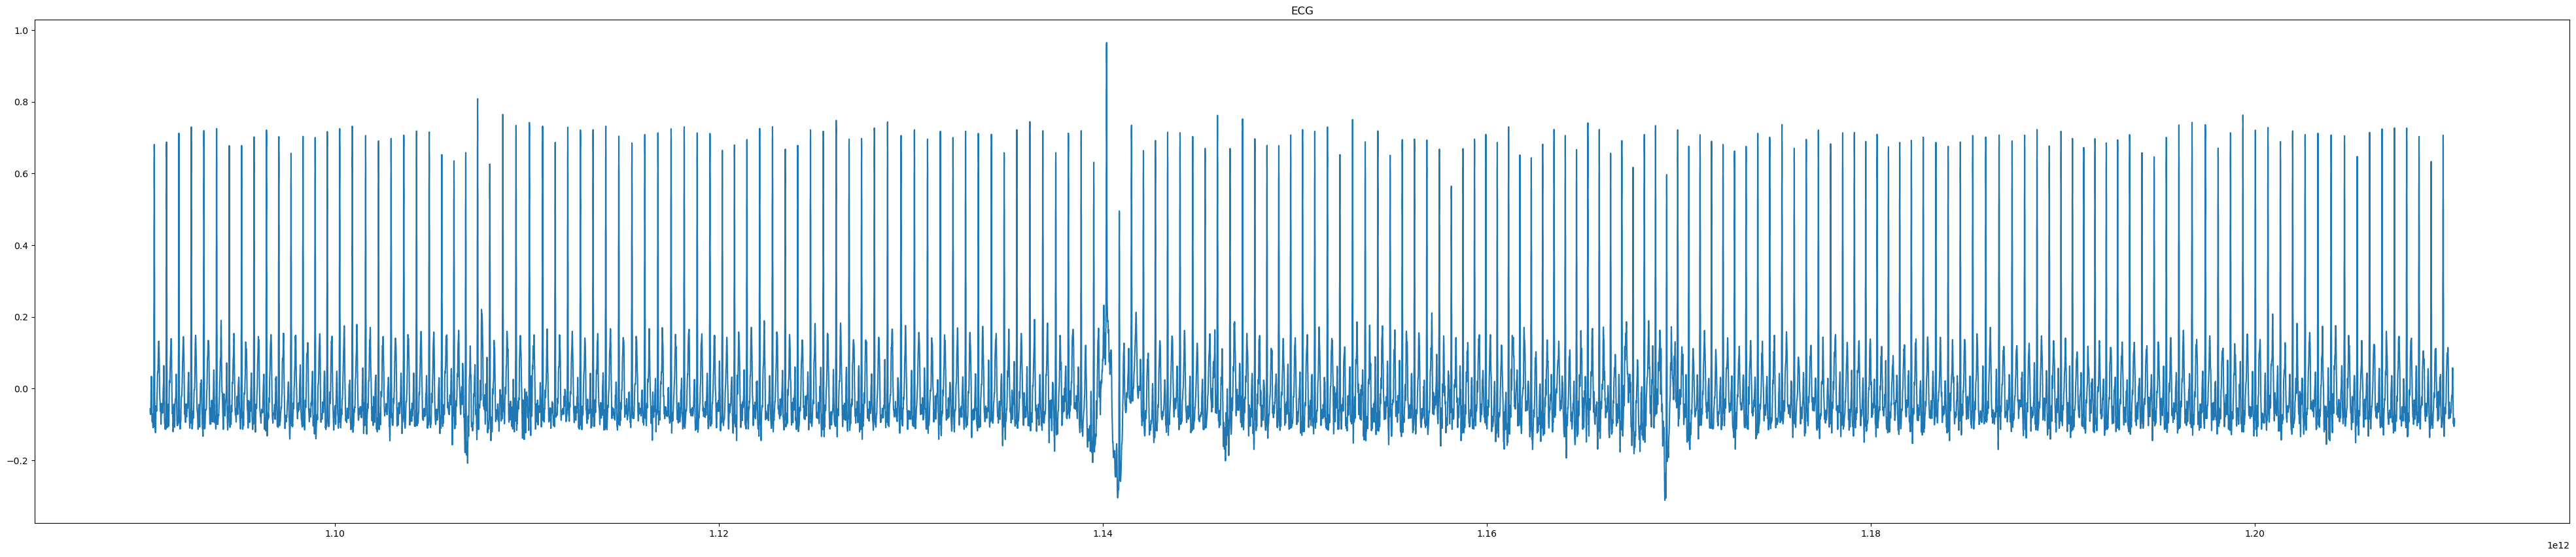

In [11]:
# plot the ECG data 1 minute before and after the obstacle
experiment_data_1min_before = experiment_data.loc[
    obstacle_trigger - pd.Timedelta(minutes=1) : obstacle_trigger + pd.Timedelta(minutes=1)
]
plt.figure(figsize=(50, 10))
plt.plot(experiment_data_1min_before.index, experiment_data_1min_before["ECG_Clean"])
plt.title("ECG")
plt.show()

---

In [12]:
@tf.keras.utils.register_keras_serializable()
class AnomalyDetector(Model):
    def __init__(self, *args, **kwargs):
        super(AnomalyDetector, self).__init__(*args, **kwargs)
        self.encoder = tf.keras.Sequential(
            [
                layers.Dense(32, activation="relu"),
                layers.Dense(16, activation="relu"),
                layers.Dense(8, activation="relu"),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(16, activation="relu"),
                layers.Dense(32, activation="relu"),
                layers.Dense(140, activation="sigmoid"),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = AnomalyDetector()

autoencoder.compile(optimizer="adam", loss="mae")

In [13]:
autoencoder = tf.keras.models.load_model("autoencoder.keras")

In [14]:
experiment_data[['ECG_Clean', 'ECG_R_Peaks']]

,ECG_Clean,ECG_R_Peaks
Timestamps,,
0 days 00:16:13.686000,-0.114138,0
0 days 00:16:13.686000,-0.120199,0
0 days 00:16:13.686000,-0.125690,0
0 days 00:16:13.686000,-0.130680,0
0 days 00:16:13.686000,-0.135214,0
...,...,...
0 days 00:36:14.646000,-0.041783,0
0 days 00:36:14.646000,-0.045146,0
0 days 00:36:14.646000,-0.048512,0


In [26]:
'''Run each heartbeat throught the model and get the error'''
heartbeat = experiment_data[["ECG_Clean", "ECG_R_Peaks"]].copy()

# remove the first peak
first_peak = heartbeat[heartbeat["ECG_R_Peaks"] == 1].index[0]
heartbeat = heartbeat[first_peak:]

ecg_beats = pd.DataFrame()
while len(heartbeat[heartbeat["ECG_R_Peaks"] == 1]) > 1:
    # get the time
    beat_start_time = heartbeat.index[0]
    # get the next peak
    next_peak = heartbeat[heartbeat["ECG_R_Peaks"] == 1].index[1]

    # get the beat
    beat = heartbeat[:next_peak].copy()

    beat.reset_index(inplace=True)
    beat = beat.drop(columns=["Timestamps", "ECG_R_Peaks"])

    # downsample
    single_beat = []
    skips = len(beat) / 140
    for i in range(0, 140):
        index_value = round(i * skips)
        single_beat.append(beat.iloc[index_value])
    single_beat = np.array(single_beat)
    single_beat = single_beat.reshape(-1)

    # convert single beat to dataframe
    single_beat = pd.DataFrame(single_beat).T

    # add the time to the dataframe
    single_beat["Time-at-0"] = beat_start_time

    # add the beat to the dataframe
    ecg_beats = pd.concat([ecg_beats, single_beat])

    heartbeat = heartbeat[next_peak:]

ecg_beats = ecg_beats.set_index("Time-at-0")

In [27]:
# Feed the data to the model
heatbeats = ecg_beats.values

# Normalize the data - MinMaxScaler
min_value = tf.convert_to_tensor(-0.3545028642229362, dtype=tf.float32)
max_value = tf.convert_to_tensor(0.8240396103014691, dtype=tf.float32)

heatbeats = (heatbeats - min_value) / (max_value - min_value)

heatbeats = tf.cast(heatbeats, dtype=tf.float32)

In [33]:
# Get the error
reconstructed_heatbeats = autoencoder(heatbeats)
reconstruction_error = tf.keras.losses.mae(heatbeats, reconstructed_heatbeats)
reconstruction_error = reconstruction_error.numpy()

# Add the error to the dataframe
ecg_beats["Reconstruction Error"] = reconstruction_error

Low Threshold => 0.04557172115892172
Medium Threshold => 0.08956580236554146


c:\Users\joelm\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


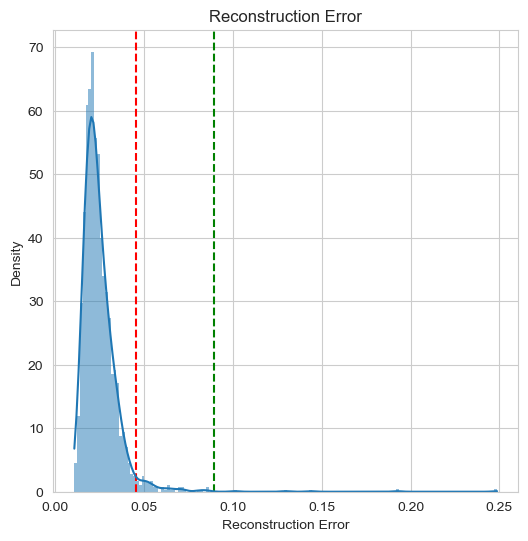

In [43]:
# plot histogram of the reconstruction error
low_threshold = np.mean(ecg_beats["Reconstruction Error"]) + 1.75 * np.std(ecg_beats["Reconstruction Error"])
print(f"Low Threshold => {low_threshold}")
medium_threshold = np.mean(ecg_beats["Reconstruction Error"]) + 5.5 * np.std(ecg_beats["Reconstruction Error"])
print(f"Medium Threshold => {medium_threshold}")

plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")
plt.axvline(low_threshold, color="r", linestyle="--")
plt.axvline(medium_threshold, color="g", linestyle="--")
sns.histplot(ecg_beats["Reconstruction Error"], kde=True, stat="density", linewidth=0)
plt.title("Reconstruction Error")
plt.show()

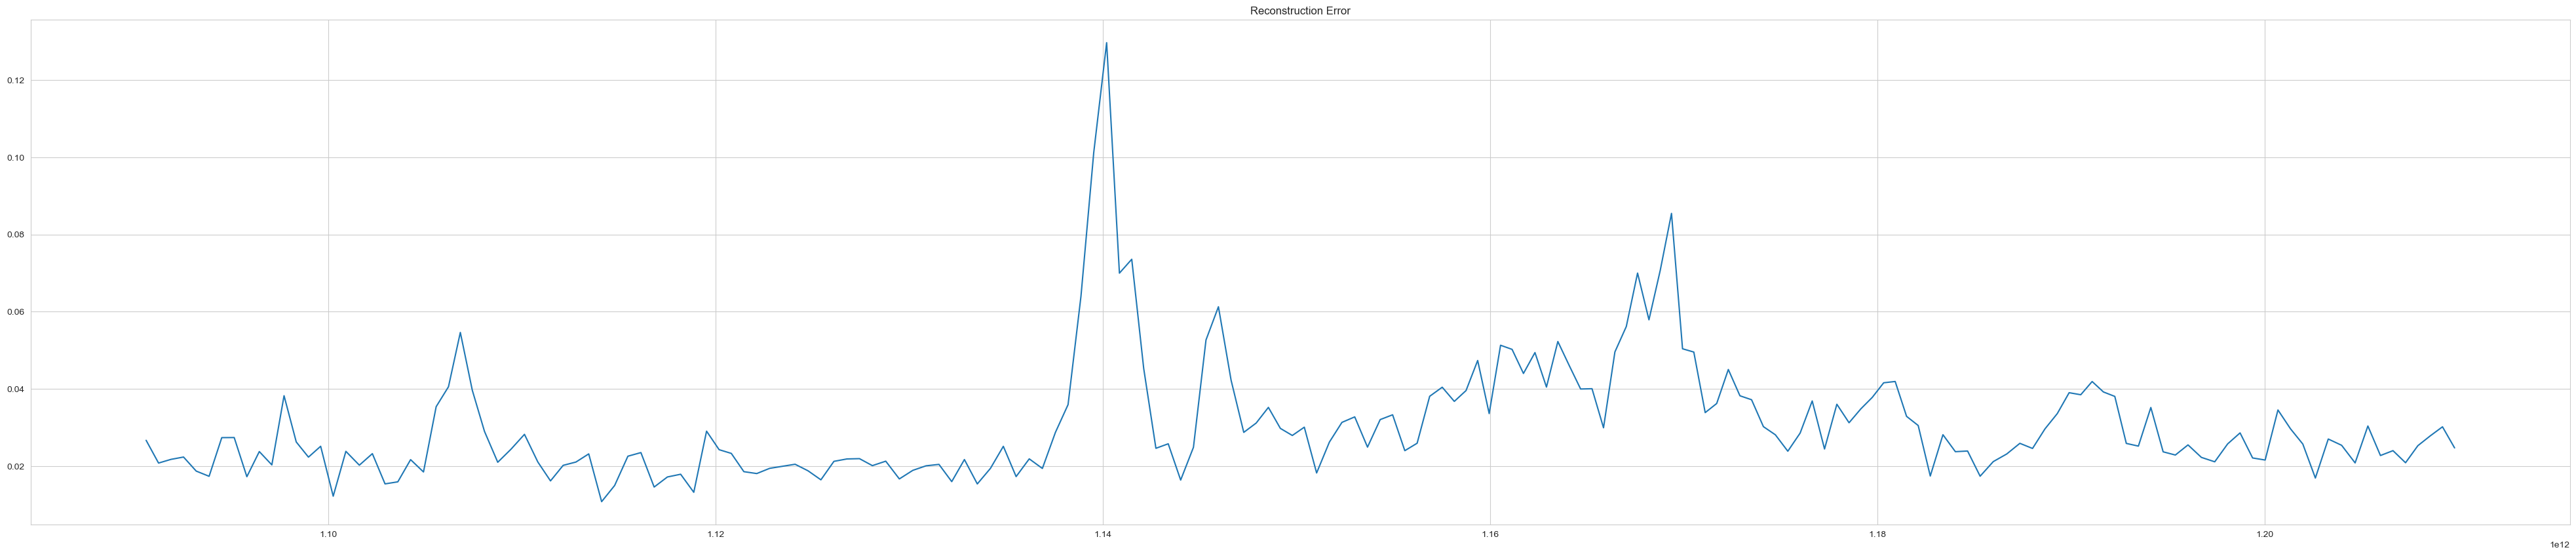

In [45]:
# plot the beats 1 minute before and after the obstacle with the reconstruction error
ecg_beats_1min_before = ecg_beats.loc[
    obstacle_trigger - pd.Timedelta(minutes=1) : obstacle_trigger + pd.Timedelta(minutes=1)
]
plt.figure(figsize=(50, 10))
plt.plot(ecg_beats_1min_before.index, ecg_beats_1min_before["Reconstruction Error"])
plt.title("Reconstruction Error")
plt.show()

In [ ]:
# Plot the Error with the ECG Data
# Plot the Error with Vehicle Data